In [10]:
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from ddm_utils import simulate_ddm, parse_sim_results
from joblib import Parallel, delayed
import pickle
from dynesty_utiils import loglike_fn, prior_transform, _quantile

import matplotlib.pyplot as plt
import numpy as np
from ex23_utils import run_vbmc, save_prior_bounds
import multiprocessing
import os
import pymc as pm
import corner
from nuts_pymc_utils import loglike_fn_NUTS

num_processes = multiprocessing.cpu_count()

# save dynesty bounds
priors_bounds = { 
    'v': [-5,5],
    'a': [1, 3],
    'w': [0.3, 0.7] 
}
with open('dynesty_priors.pkl', 'wb') as f:
    pickle.dump(priors_bounds, f)

# save VBMC bounds
prior_bounds = { 'v_low': -5, 'v_high': 5, 'a_low': 1, 'a_high': 3, 'w_low': 0.3, 'w_high': 0.7 }
save_prior_bounds(prior_bounds)

# search bounds for VBMC
lb = np.array([-5, 1, 0.3]); ub = np.array([5, 3, 0.7])
plb = np.array([-4.9,1.1,0.31]); pub = np.array([4.9,2.9,0.69])

# data sim
# N_trials_arr = [100, 500, 1000, 5000]
N_trials_arr = [100]


corner_span = [(-0.2, 0.75), (1.6, 2.4), (0.4, 0.6)]
param_labels = ['v', 'a', 'w']
true_v = 0.2; true_a = 2; true_w = 0.5
true_arr = [true_v, true_a, true_w]

save_path = "/home/rka/Pictures/test" 

N_sim = 100
# for N_sim in N_trials_arr:
print(f'################################ processing {N_sim} ################################')

# save data
sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(true_v, true_a) for _ in range(N_sim))
choices, RTs = parse_sim_results(sim_results)
with open('sample_rt.pkl', 'wb') as f:
    pickle.dump(RTs, f)
with open('sample_choice.pkl', 'wb') as f:
    pickle.dump(choices, f)
data_dict = {'choices': choices, 'RTs': RTs}

# Nested sampling
pool = multiprocessing.Pool(processes=num_processes)
ndim = 3
sampler = NestedSampler(loglike_fn, prior_transform, ndim, pool=pool, queue_size=num_processes)
sampler.run_nested()
pool.close()
pool.join()
nested_samp_results = sampler.results

# NS Corner plots
title_kwargs = {'fontsize': 10}  # Increase the title font size
label_kwargs = {'fontsize': 10}  # Increase the label font size
tick_labelsize = 12

fig, axes = dyplot.cornerplot(nested_samp_results, color='blue', truths=np.array(true_arr),
                              truth_color='black', show_titles=True,
                              max_n_ticks=5, labels=param_labels,
                              label_kwargs=label_kwargs,
                              title_kwargs=title_kwargs, span=corner_span)

# Adjust tick parameters
for ax in axes.reshape(-1):  # Flatten the axes array and iterate through each subplot
    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

filename_ns = f"TEMP_corner_nested_sample_{N_sim}.png"
fig.savefig(filename_ns)
plt.close(fig)


    # VBMC
# x0 = np.array([np.random.uniform(plb[0], pub[0]), np.random.uniform(plb[1], pub[1]), np.random.uniform(plb[2], pub[2])])
# vp, results = run_vbmc(x0, lb, ub, plb, pub)

# v_a_w, _ = vp.sample(int(1e5))
# v_samp = v_a_w[:,0]; a_samp = v_a_w[:,1]; w_samp = v_a_w[:,2]
# combined_samples = np.transpose(np.vstack((v_samp, a_samp, w_samp)))
# figure = corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975],range=corner_span, truths=true_arr)
# # filename = f"corner_vbmc_{N_sim}.png"  # You can change the filename as needed
# # plt.savefig(os.path.join(save_path, filename))
# plt.close(figure)  # Close the figure to free 
# plt.show()



################################ processing 100 ################################


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -162.869 +/-0.001.


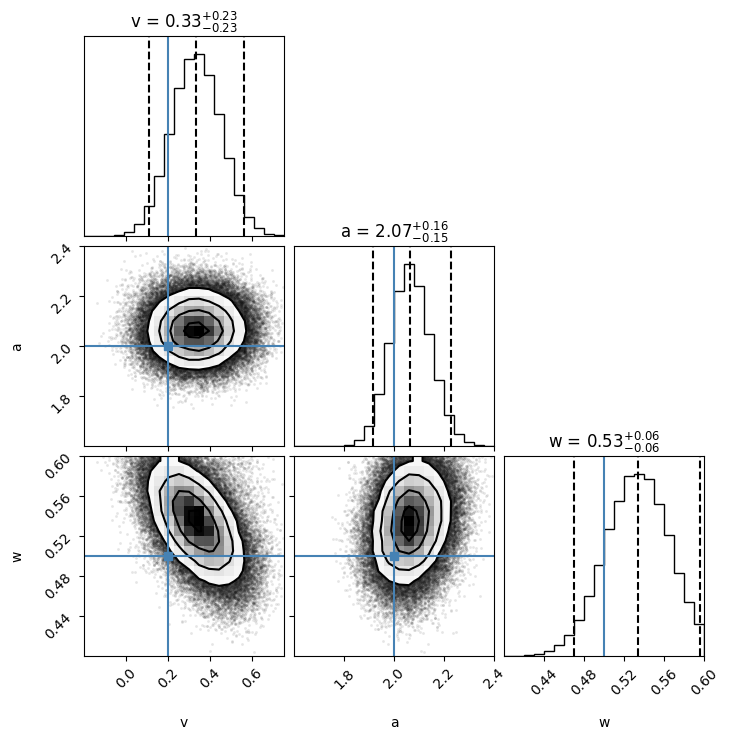

In [2]:
    # VBMC
x0 = np.array([np.random.uniform(plb[0], pub[0]), np.random.uniform(plb[1], pub[1]), np.random.uniform(plb[2], pub[2])])
vp, results = run_vbmc(x0, lb, ub, plb, pub)

v_a_w, _ = vp.sample(int(1e5))
v_samp = v_a_w[:,0]; a_samp = v_a_w[:,1]; w_samp = v_a_w[:,2]
combined_samples = np.transpose(np.vstack((v_samp, a_samp, w_samp)))
figure = corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975],range=corner_span, truths=true_arr)
# filename = f"corner_vbmc_{N_sim}.png"  # You can change the filename as needed
# plt.savefig(os.path.join(save_path, filename))
# plt.close(figure)  # Close the figure to free 
plt.show()

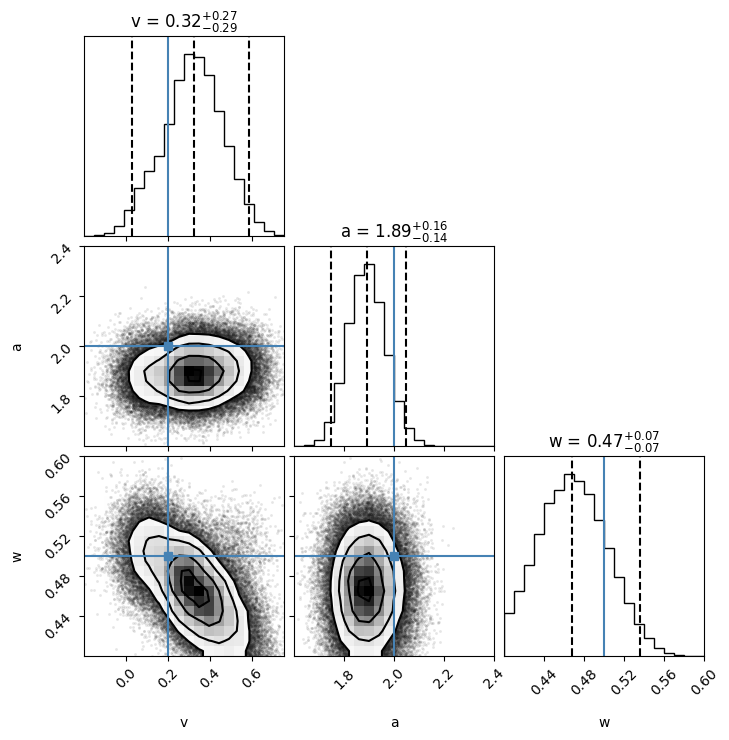

In [6]:
figure = corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975],range=corner_span, truths=true_arr)
# filename = f"corner_vbmc_{N_sim}.png"  # You can change the filename as needed
# plt.savefig(os.path.join(save_path, filename))
# plt.close(figure)  # Close the figure to free 
# plt.show()
figure.savefig(f"TEMP_corner_vbmc_{N_sim}.png")